In [5]:
import re
import time
import pandas as pd
import pylab as pl
import numpy as np
import scipy.spatial as ss
from scipy.cluster import hierarchy
from scipy.spatial.distance import pdist
import sklearn.cluster as sc
import sklearn.manifold as sm
import sklearn.datasets as ds
import sklearn.metrics as smt
from sklearn.mixture import GaussianMixture
from sklearn.cluster import AgglomerativeClustering
from sklearn.feature_extraction.text import TfidfVectorizer

import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, ClusterMixin

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

# Plotting config
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [6]:



class Clustering(BaseEstimator, ClusterMixin):
    """
    Implement clustering algorithm according 
    """
    def __init__(self, metric, linkage='single', n_clasters=2, **kwargs):
        """
        metric - string with name of metric, for example, euclidean
        Please add necessary algoritm parameters to class constructor.
        """
        self.n_clasters = n_clasters
        self.linkage = linkage
        self.ind = 0
        self.dendenogram_info = np.array([])
        self.max_number_of_classes = 0
        
        if metric == 'euclidian':
            self.distance = self.__euclidian_distance
        elif metric == 'cosine':
            self.distance = self.__cosine_distance
        elif metric == 'words':
            self.distance = self.__words_distance
        else:
            self.distance = self.__euclidian_distance
            
        if linkage == 'single':
            self.calculating_coefficients = self.__single_coefficients
        elif linkage == 'complete':
            self.calculating_coefficients = self.__complete_coefficients
        elif linkage == 'average':
            self.calculating_coefficients = self.__average_coefficients
        else:
            print("Error: Incorrect linkage name")
            self.calculating_coefficients = self.__single_coefficients
            
        pass
    
    def __euclidian_distance(self, a, b):
        a = np.array(a)
        b = np.array(b)
        return np.sqrt(np.sum((a - b) ** 2))

    def __cosine_distance(self, a, b):
        a = np.array(a)
        b = np.array(b)
        t = np.dot(a, b)
        p = sqrt((a ** 2).sum()) * sqrt((b ** 2).sum())
        if t / p > 1:
            return 0
        return np.arccos(t / p)

    def __words_distance(self, a, b):
        return 1 - len(Counter(a) & Counter(b)) / len(Counter(a) | Counter(b))
    
    def update_tree(self, tree, pos_i, pos_j):
        self.max_number_of_classes += 1
        mas = np.zeros(len(tree))
        for i in range(len(tree)):
            mas[i] = tree[i]
            if tree[i] in [tree[int(pos_j)], tree[int(pos_i)]]:
                mas[i] = self.max_number_of_classes
        return mas
    
    def __single_coefficients(self, tree, x, y):
        return [1/2, 1/2, -1/2]
    
    def __complete_coefficients(self, tree, x, y):
        return [1/2, 1/2, 1/2] 
    
    def __average_coefficients(self, tree, x, y):
        c = [0, 0, 0]
        for i in tree:
                if i == tree[x]:
                    c[0] += 1
                if i == tree[y]:
                    c[1] += 1
        c[2] = c[0] + c[1]
        c[0] = c[0] / c[2]
        c[1] = c[1] / c[2]
        c[2] = 0
        return c
    
    def update_matrix(self, matrix_of_distances, tree, x, y):
        coefficient = [0, 0, 0]
        x = int(x)
        y = int(y)
        tree_x = np.array(matrix_of_distances[x])
        tree_y = np.array(matrix_of_distances[y])
        k = len(matrix_of_distances)
        coefficient = self.calculating_coefficients(tree, x, y)
        for i in range(k):
            if tree[i] in [tree[x], tree[y]]:
                for j in range(k):
                    tmp = coefficient[0] * tree_x[j] + coefficient[1] * tree_y[j] + coefficient[2] * abs(tree_x[j] - tree_y[j])
                    matrix_of_distances[i][j] = tmp
                    matrix_of_distances[j][i] = tmp
        return matrix_of_distances
    
    def search_minimum(self, matrix_of_distances, tree):
        k = len(matrix_of_distances)
        min_ = np.array([0, 0, -1])
        for i in range(k):
            for j in range(i + 1, k):
                if (min_[2] > matrix_of_distances[i][j] or min_[2] == -1) and tree[i] != tree[j]:
                    min_ = np.array([i, j, matrix_of_distances[i][j]])
        return min_
    
    def number_repr(self, tree, claster):
        number_repr = 0
        for i in tree:
            if i == claster:
                number_repr += 1
        return number_repr
    
    def build_tree(self, x):
        k = len(x)
        self.max_number_of_classes = k - 1
        tree = np.arange(0, k ** 2).reshape(k, k)
        
        matrix_of_distances = np.zeros((k, k))
        for i in range(k):
            for j in range(k):
                matrix_of_distances[i][j] = self.distance(x[i], x[j])
                matrix_of_distances[j][i] = matrix_of_distances[i][j]
                
        for i in range(1, k):
            minimum = self.search_minimum(matrix_of_distances, tree[i - 1])
            prev_x = tree[i - 1][int(minimum[0])]
            prev_y = tree[i - 1][int(minimum[1])]
            tree[i] = self.update_tree(tree[i - 1], minimum[0], minimum[1])
            matrix_of_distances = self.update_matrix(matrix_of_distances, tree[i - 1], minimum[0], minimum[1])
            minimum = np.append(minimum, self.number_repr(tree[i], tree[i][int(minimum[0])]))
            minimum[0] = prev_x
            minimum[1] = prev_y
            self.dendenogram_info = np.append(self.dendenogram_info, minimum)

        self.dendenogram_info = self.dendenogram_info.reshape(-1, 4)
        self.tree = tree
        return tree[k - self.n_clasters]
    
    def fit_predict(self, x):
        """
        Use data matrix x to compute model parameters and predict clusters
        """
        return self.build_tree(x)
    
    def cut_tree(self, height):
        i = 0
        while (i < len(self.dendenogram_info)) and (self.dendenogram_info[i][2] < height):
            i += 1
        return self.tree[i]
    
    def plot_dendrogram(self):
        """
        Try to visualize our data
        """
        fig = plt.figure()
        ax = fig.add_subplot(111)
        fig.set_figheight(10)
        fig.set_figwidth(20)
        hierarchy.dendrogram(self.dendenogram_info)
        pass

# Test


In [7]:
iris = ds.load_iris()
x_iris = iris.data[:100]
y_iris = iris.target[:100]

<Figure size 720x360 with 0 Axes>

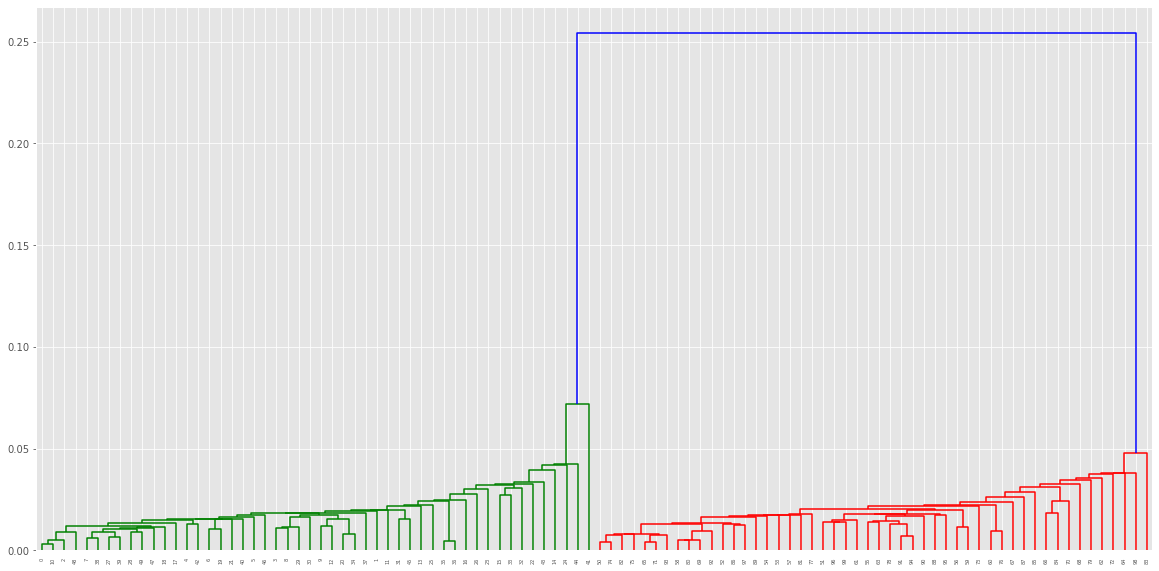

In [8]:
pl.figure(figsize=(10, 5))
myclf = Clustering('cosine', 'single', 2)
t = myclf.fit_predict(x_iris)
myclf.plot_dendrogram()
plt.show()

<Figure size 720x360 with 0 Axes>

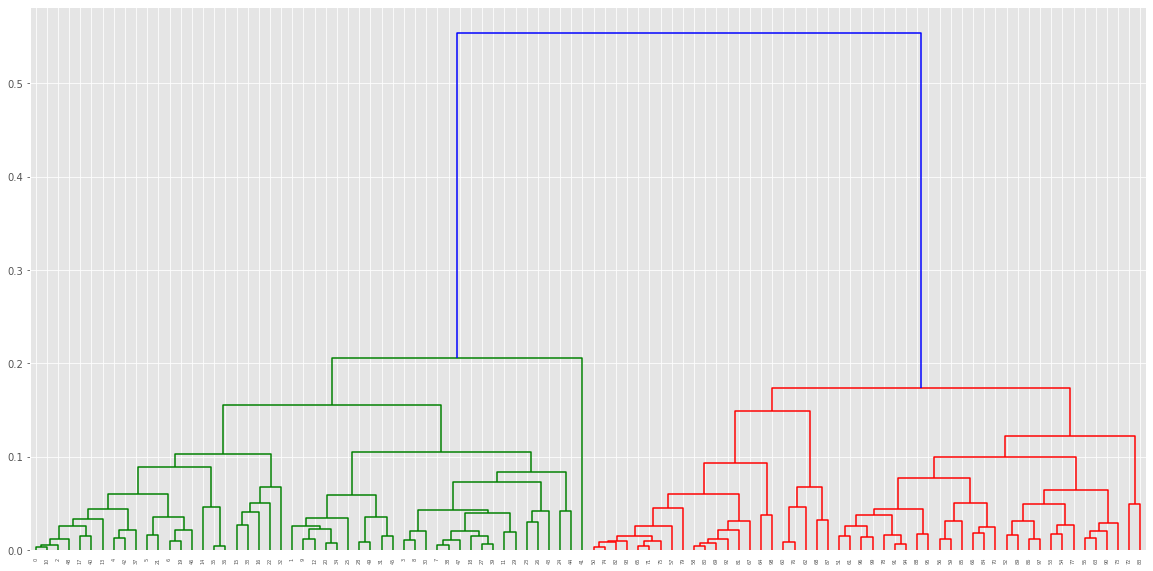

In [9]:
pl.figure(figsize=(10, 5))
myclf = Clustering('cosine', 'complete', 2)
t = myclf.fit_predict(x_iris)
t.shape
myclf.plot_dendrogram()
plt.show()

In [11]:
сustum_aggl = Clustering(metric='euclidian')
aggl_t0 = time.time()
aggl_pred = сustum_aggl.fit_predict(x_iris)
aggl_diff = time.time() - aggl_t0
aggl_score = smt.adjusted_rand_score(y_iris, aggl_pred)
print ("Our AGGL score {}. Our AGGL time {}".format(aggl_score, aggl_diff))

Our AGGL score 1.0. Our AGGL time 0.6981785297393799
